In [0]:
# PySpark SQL
from pyspark.sql.functions import col, when, to_timestamp, month
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# PySpark ML
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import (
    StringIndexer, 
    VectorAssembler, 
    StandardScaler,
    PCA
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import VectorUDT

# XGBoost for Spark
from xgboost.spark import SparkXGBClassifier

# MLflow
import mlflow
from mlflow import pyfunc

# Python Data Science Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import json
from itertools import product
from sklearn.metrics import confusion_matrix

In [0]:
display(
    dbutils.fs.ls("dbfs:/student-groups/Group_4_1/")
)

path,name,size,modificationTime
dbfs:/student-groups/Group_4_1/08f51b3e-da58-4e4d-9da0-e331eeb9b245/,08f51b3e-da58-4e4d-9da0-e331eeb9b245/,0,1763856554494
dbfs:/student-groups/Group_4_1/3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,0,1763856554494
dbfs:/student-groups/Group_4_1/5Y/,5Y/,0,1763856554494
dbfs:/student-groups/Group_4_1/86b0469f-b9c6-4218-8869-aaeb39753cac/,86b0469f-b9c6-4218-8869-aaeb39753cac/,0,1763856554494
dbfs:/student-groups/Group_4_1/airport_codes.parquet/,airport_codes.parquet/,0,1763856554494
dbfs:/student-groups/Group_4_1/best_preds_final_test_5Y.parquet/,best_preds_final_test_5Y.parquet/,0,1763856554495
dbfs:/student-groups/Group_4_1/c505789c-684a-47b9-84e1-24d52ec7cb99/,c505789c-684a-47b9-84e1-24d52ec7cb99/,0,1763856554495
dbfs:/student-groups/Group_4_1/cv_model/,cv_model/,0,1763856554495
dbfs:/student-groups/Group_4_1/df_test_scaled.parquet/,df_test_scaled.parquet/,0,1763856554495
dbfs:/student-groups/Group_4_1/df_test_scaled_checkpoint.parquet/,df_test_scaled_checkpoint.parquet/,0,1763856554495


In [0]:
# 1 Removing duplicates, cancellation flights and column with null values > 12%
ch1 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_1/"
# 2 Remove data leakage columns and other columns after review
ch2 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
ch3 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_3/"
# 4 Adding external holiday data
ch4 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
ch5 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_5"

In [0]:
# Removing duplicates, cancellation flights, column with null values > 12%  and Data leakage column
yd1 = "dbfs:/student-groups/Group_4_1/otpw_clean_1Y_checkpoint_1/"
# Remove other columns after review
yd2 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd3 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_3/"
# Adding external holiday data   new columns included in this step  - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd4 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
yd5 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_5/"

# removed the holiday columns in the process. I’ve added them back now, and all the categorical variables are one-hot encoded with the ohe prefix.
yd7 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_7/"

In [0]:
def show_schema_and_sample(path, n=10):
    df = spark.read.parquet(path)
    df.printSchema()
    display(df.limit(n))

show_schema_and_sample(yd7)

root
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- HourlyAltimeterSetting: double (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY_GROUP: integer (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- STATION: long (nullable = true)
 |-- two_hours_prior_depart_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time: timestamp (nullable = true)
 |-- DISTANCE_GROUP: integer (nullab

HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
file_locations = {
}

file_location_1y = {
    "1_year_data_weighted_t_b": yd7
}

In [0]:
cols_to_remove = [
    "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyDewPointTemperature",
    "origin_airport_lon",
    "DISTANCE_GROUP",
    "month",
    "wind_dir_cos",
    "DEP_TIME_BLK_ohe",
    "origin_region_ohe",
    "FL_DATE",
    "four_hours_prior_depart_UTC",
    'CRS_ARR_TIME', 'CRS_DEP_TIME',
    'CRS_ELAPSED_TIME'
]

In [0]:
chosen_cols = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    # "DEP_TIME",
    "DEP_DELAY_GROUP",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    # "DISTANCE",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    # "OP_CARRIER_FL_NUM",
    # "ELEVATION",
    "DEST_AIRPORT_ID",
    "origin_airport_lon",
    "origin_airport_lat",
    "day_of_week",
    # "dest_airport_lat",
    # "FL_DATE",
    # "QUARTER",
    "LONGITUDE",
    # "CRS_ELAPSED_TIME",
    # "month",
    # "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos",
    # "HourlyPrecipitation_was_missing",
    # "ORIGIN_ohe",
    # "TAIL_NUM_ohe",
    # "origin_region_ohe",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "season",
    "hour_of_day",
    "is_weekend"
]

In [0]:
def load_df(file_dict):
    dfs = []
    for key, file_location in file_dict.items():
        try:
            if len(dbutils.fs.ls(file_location)) > 0:
                dfs.append({"name": key, "df": spark.read.parquet(file_location)})
            else:
                print(f"Skipping empty path: {file_location}")
        except Exception as e:
            print(f"Skipping invalid path: {file_location} ({e})")
    return dfs

dfs_1y = load_df(file_location_1y)

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"First 10 rows of dfs_1y[{i}]:")
    display(item["df"].limit(10))

First 10 rows of dfs_1y[0]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
PCA_columns = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindDirection",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyWindSpeed",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ARR_TIME",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    "DEST_AIRPORT_ID",
    "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME",
    "ELEVATION",
    "origin_airport_lon",
    "origin_airport_lat",
    "dest_airport_lon",
    "dest_airport_lat",
    "LONGITUDE",
    "CRS_ELAPSED_TIME",
    "month",
    "day_of_week",
    "HourlyPrecipitation_was_missing",
    "wind_deg_imputed",
    "wind_dir_sin",
    "wind_dir_cos",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft"
]

def three_month_modifier_for_pca(df):
    to_double_cols = [
        "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
        "LATITUDE", "DISTANCE_GROUP", "DISTANCE", "CRS_ARR_TIME",
        "DAY_OF_MONTH", "ORIGIN_AIRPORT_ID", "OP_CARRIER_FL_NUM",
        "CRS_DEP_TIME", "ELEVATION", "DEST_AIRPORT_ID",
        "origin_airport_lon", "origin_airport_lat",
        "dest_airport_lon", "dest_airport_lat",
        "LONGITUDE", "CRS_ELAPSED_TIME", "QUARTER"
    ]

    for c in to_double_cols:
        if c in df.columns:
            df = df.withColumn(c, col(c).cast("double"))

    return df

In [0]:
PCA_1y = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "CRS_ARR_TIME",
    "QUARTER",
    "day_of_week",
    "DAY_OF_MONTH",
    "CRS_DEP_TIME",
    "OP_CARRIER_FL_NUM",
    "dest_airport_lat",
    "ELEVATION",
    "LONGITUDE",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ELAPSED_TIME",
    "month",
    "dest_airport_lon",
    "origin_airport_lon",
    "origin_airport_lat",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft",
    "wind_deg_raw",
    "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos"
]

In [0]:
target_selected = list(set(chosen_cols + PCA_columns + PCA_1y))

## Main Dataset creation

In [0]:
# Leveraged from Eric
def create_delay_groups(df):
    df_new = df.withColumn(
        "DEP_DELAY_GROUP_CLASSIFIED",
        when(col("DEP_DELAY_GROUP").isin(-2, -1), "not_delayed")
        .when(col("DEP_DELAY_GROUP").isin(0), "not_delayed")
        .otherwise("delayed"),
    )
    return df_new

In [0]:
def prep_for_rf(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    banned = {label_col, "DEP_DELAY_GROUP"}

    # 1) clear any stale ML metadata
    df = df.select([F.col(c).alias(c, metadata={}) for c in df.columns])

    # 2) normalize strings, then cast ALL non-label strings to double
    for c, t in df.dtypes:
        if t == "string" and c not in banned:
            df = df.withColumn(c, F.trim(F.col(c)))
            df = df.withColumn(c, F.when(F.col(c) == "", None).otherwise(F.col(c)))
            df = df.withColumn(c, F.col(c).cast("double"))  # non-numeric → null

    # 3) fill NaNs in numerics (so assembler/RF won’t choke)
    numeric_cols = [c for c, t in df.dtypes if c not in banned and t in {"double","float","int","bigint"}]
    if numeric_cols:
        df = df.fillna(0.0, subset=numeric_cols)
    else:
        raise ValueError("Still no numeric columns after casting — check schema/label name.")

    return df

In [0]:
## SPLIT_FN
def train_test_split(df, *args):
    # Train / test split
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=1234)
    return train_df, test_df

def month_split(df, min_month, max_month):
    """ month split train/eval and test/predict - greater than and equal to max month"""
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= min_month)
    test_df = df.filter(month(to_timestamp(col("DATE"))) >= max_month)
    return train_df, test_df
### END SPLIT FN

def month_split_end_at_max_month(df, min_month, max_month):
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= min_month)
    test_df = df.filter(month(to_timestamp(col("DATE"))) == max_month)
    return train_df, test_df

def quarter_split(df, min_quarter, max_quarter):
    """
    Split DataFrame into train and test sets based on quarter.
    For q1 split with q2: train = Q1, test = Q2
    For q1+q2 split with q3: train = Q1 and Q2, test = Q3
    """
    quarter_col = F.quarter(to_timestamp(col("DATE")))
    train_df = df.filter(quarter_col <= min_quarter)
    test_df = df.filter(quarter_col == max_quarter)
    return train_df, test_df

def get_feature_cols(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    # Numeric feature columns only (excluding label and raw group)
    feature_cols = [
        c for c, t in df.dtypes
        if t in ("int", "bigint", "double", "float")
        and c not in [label_col, "DEP_DELAY_GROUP"]
    ]
    return feature_cols

def drop_columns(df, columns_to_drop):
    for col_name in columns_to_drop:
        df = df.drop(col_name)
    return df

In [0]:
def get_train_test_filter_df(
    item, split_fn, drop_cols, lower, upper, elected_cols=None, pca_col="features_with_pca"
):
    df = item["df"]
    name = item["name"]
    df_dg = create_delay_groups(df)
    df_clean = prep_for_rf(df_dg)
    # Only drop columns that exist, but never drop DEP_DELAY_GROUP_CLASSIFIED
    cols_to_drop = [col for col in drop_cols if col in df_clean.columns and col != "DEP_DELAY_GROUP_CLASSIFIED"]
    df_filtered = drop_columns(df_clean, cols_to_drop)
    if elected_cols is not None:
        # Always include the PCA column if it exists and DEP_DELAY_GROUP_CLASSIFIED
        cols_to_select = []
        if pca_col in df_filtered.columns:
            pass
            # cols_to_select.append(pca_col). # Ignore PCA column vector due to memory issues
        cols_to_select += [c for c in elected_cols if c != pca_col and c in df_filtered.columns]
        if "DEP_DELAY_GROUP_CLASSIFIED" not in cols_to_select and "DEP_DELAY_GROUP_CLASSIFIED" in df_filtered.columns:
            cols_to_select.append("DEP_DELAY_GROUP_CLASSIFIED")
        df_filtered = df_filtered.select(*cols_to_select)
        feature_cols = [c for c in cols_to_select if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    else:
        feature_cols = [c for c in df_filtered.columns if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    train_df, test_df = split_fn(df_filtered, lower, upper)

    return {
        "name": name,
        "train_df": train_df.cache(),
        "test_df": test_df.cache(),
        "feature_cols": feature_cols
    }

def model_pipeline(df_list, split_fn, lower, upper, drop_cols=None, elected_cols=None):
    df_split = []
    if drop_cols is None:
        drop_cols = []

    for item in df_list:
        df_items = get_train_test_filter_df(item, split_fn, drop_cols, lower, upper, elected_cols)
        df_split.append(df_items)

    return df_split

### Dataset curating

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["df"].columns)

Column names for dfs_1y[0] (1_year_data_weighted_t_b):
['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyAltimeterSetting', 'DEP_TIME', 'DEP_DELAY_GROUP', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'CRS_ARR_TIME', 'LATITUDE', 'DATE', 'STATION', 'two_hours_prior_depart_UTC', 'sched_depart_date_time_UTC', 'sched_depart_date_time', 'DISTANCE_GROUP', 'DISTANCE', 'four_hours_prior_depart_UTC', 'DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'ELEVATION', 'dest_airport_lon', 'DEST_AIRPORT_ID', 'origin_airport_lon', 'origin_airport_lat', 'day_of_week', 'dest_airport_lat', 'FL_DATE', 'QUARTER', 'LONGITUDE', 'CRS_ELAPSED_TIME', 'month', 'ts', 'HourlyWindDirection_deg', 'wind_dir_sin', 'wind_dir_cos', 'HourlyPrecipitation_was_missing', 'has_CLR', 'CLR_height_ft', 'has_FEW', 'FEW_height_ft', 'has_SCT', 'SCT_height_ft', 'has_BKN', 'BKN_

In [0]:
df_split_1y = model_pipeline(dfs_1y, month_split, 9, 10, cols_to_remove,  target_selected)

In [0]:
for i, item in enumerate(df_split_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["train_df"].columns)
    print(f"First 5 rows of train_df for dfs_1y[{i}] ({item['name']}):")
    display(item["train_df"].limit(5))

Column names for dfs_1y[0] (1_year_data_weighted_t_b):
['day_of_week', 'has_SCT', 'HourlyDryBulbTemperature', 'is_us_holiday', 'OP_CARRIER_FL_NUM', 'is_summer_peak', 'hour_of_day', 'CLR_height_ft', 'dest_airport_lat', 'BKN_height_ft', 'origin_airport_lat', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'has_OVC', 'dest_airport_lon', 'has_CLR', 'HourlyVisibility', 'has_FEW', 'SCT_height_ft', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'is_weekend', 'HourlyWindDirection_deg', 'season', 'FEW_height_ft', 'OVC_height_ft', 'is_holiday_window', 'has_BKN', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[0] (1_year_data_weighted_t_b):


day_of_week,has_SCT,HourlyDryBulbTemperature,is_us_holiday,OP_CARRIER_FL_NUM,is_summer_peak,hour_of_day,CLR_height_ft,dest_airport_lat,BKN_height_ft,origin_airport_lat,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,has_OVC,dest_airport_lon,has_CLR,HourlyVisibility,has_FEW,SCT_height_ft,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,is_weekend,HourlyWindDirection_deg,season,FEW_height_ft,OVC_height_ft,is_holiday_window,has_BKN,HourlyRelativeHumidity,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
4,0,4.0,0,5076,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,5,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,3.0,30.13,0,300.0,0.0,0,0,0,0,76.0,6.0,-0.8660254037844386,delayed
2,0,15.0,0,5212,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,17,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,12.0,29.78,0,10.0,0.0,0,0,1,0,59.0,6.0,0.17364817766693033,not_delayed
2,0,72.0,0,5097,1,19,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,21,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,66.0,29.7,0,350.0,0.0,0,0,0,0,71.0,15.0,-0.1736481776669304,not_delayed
5,0,65.0,0,4896,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,31,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,61.0,29.94,0,260.0,0.0,0,0,0,0,78.0,7.0,-0.984807753012208,not_delayed
7,0,58.0,0,5457,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,23,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,55.0,30.1,1,50.0,0.0,0,0,0,0,84.0,5.0,0.766044443118978,not_delayed


### Modeling

In [0]:
def train_random_forest(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train a Random Forest classifier on the given dataframe.
    Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # Random Forest classifier
    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol="class_weight",
        numTrees=150,
        maxDepth=8,
        seed=42,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)

    rf_model = rf_pipeline.fit(df_train)

    pred_test = rf_model.transform(df_test)

    return rf_model, pred_test

In [0]:
def train_xgboost(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train an XGBoost classifier using xgboost.spark.SparkXGBClassifier
    on the given dataframe. Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # XGBoost classifier
    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col="class_weight",
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)

    xgb_model = xgb_pipeline.fit(df_train)

    pred_test = xgb_model.transform(df_test)

    return xgb_model, pred_test


In [0]:
def add_class_weights(label_col="DEP_DELAY_GROUP_CLASSIFIED", weight_col="class_weight"):
    """
    Returns an adjust_fn(train_df, test_df) that adds a class_weight column to train_df
    based on label distribution, and leaves test_df unchanged.
    """

    def _adjust(train_df, test_df):
        # counts per class on training set
        counts = train_df.groupBy(label_col).count().withColumnRenamed("count", "cnt")
        total = counts.agg(F.sum("cnt")).first()[0]
        k = counts.count()

        # w_c = N / (K * n_c)  -> average weight ~ 1
        weights_df = counts.withColumn(
            weight_col,
            (F.lit(float(total)) / (F.lit(float(k)) * F.col("cnt")))
        )

        # attach weights to training rows
        train_with_weights = train_df.join(
            weights_df.select(label_col, weight_col),
            on=label_col,
            how="left"
        )

        return train_with_weights, test_df

    return _adjust

In [0]:
def modeling_pipeline(df_items, modeling_fn, model_save_path="", model_name="", *adjust_fns):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"
    time_save_path = f"{model_save_path}/{model_name}_train_time.txt"

    # Try to load model, predictions, and timing if they exist
    try:
        model = PipelineModel.load(save_path)
        pred_test = spark.read.parquet(pred_test_save_path)
        try:
            # Read training time from text file, handle empty or missing file
            time_content = dbutils.fs.head(time_save_path, 1000)
            train_time = float(time_content.strip())
        except Exception as e:
            print(e)
            print("failed to retrieve time")
            train_time = None
        print(f"Loaded model from {save_path}")
        print(f"Loaded predictions from {pred_test_save_path}")
        print(f"Loaded training time from {time_save_path}: {train_time}")
        return {
            "model": model,
            "pred_test": pred_test,
            "name": model_name,
            "time": train_time
        }
    except Exception:
        print(f"training {model_name}")

    train_df = df_items["train_df"]
    test_df = df_items["test_df"]
    feature_cols = df_items["feature_cols"]

    # Make any adjustments as needed
    for adjust_fn in adjust_fns:
        train_df, test_df = adjust_fn(train_df, test_df)

    start_time = time.time()
    model, pred_test = modeling_fn(train_df, test_df, feature_cols)
    end_time = time.time()
    train_time = end_time - start_time

    if model_save_path != "" and model_name != "":
        print(f"Model saved to {save_path}")
        model.write().overwrite().save(save_path)
        pred_test.write.mode("overwrite").parquet(pred_test_save_path)
        try:
            dbutils.fs.put(time_save_path, str(train_time), overwrite=True)
            print(f"Training time saved to {time_save_path}: {train_time}")
        except Exception as e:
            print(f"Could not save training time: {e}")
        print(f"Predictions saved to {pred_test_save_path}")

    return {
        "model": model,
        "pred_test": pred_test,
        "name": model_name,
        "time": train_time
    }

In [0]:
def train_models(df_split, modeling_fn, model_prefix):
    models = []
    for i in range(len(df_split)):
        model = modeling_pipeline(
            df_split[i],
            modeling_fn,
            f"dbfs:/student-groups/Group_4_1/{model_prefix}",
            df_split[i]["name"],
            add_class_weights()
        )
        models.append(model)
    return models

In [0]:
def delete_model_if_exists(model_save_path, model_name):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"
    # Remove model directory if exists
    try:
        dbutils.fs.rm(save_path, True)
        print(f"Deleted model directory: {save_path}")
    except Exception as e:
        print(f"Could not delete model directory: {save_path} ({e})")
    # Remove predictions directory if exists
    try:
        dbutils.fs.rm(pred_test_save_path, True)
        print(f"Deleted predictions directory: {pred_test_save_path}")
    except Exception as e:
        print(f"Could not delete predictions directory: {pred_test_save_path} ({e})")

In [0]:
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[4]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[4]["name"])


# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[4]["name"])

# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model1_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model2_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model3_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model4_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model5_1y", df_split_1y[4]["name"])

## model run - EXPERIMENTS

XG Boost

In [0]:
xg_models_1y = train_models(df_split_1y, train_xgboost, "xgboost_model_1y")

Loaded model from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_t_b
Loaded predictions from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_t_b_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_t_b_train_time.txt: 94.36764621734619


Random forest

In [0]:
rf_models_1y = train_models(df_split_1y, train_random_forest, "rf_model_1y")

Loaded model from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_t_b
Loaded predictions from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_t_b_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_t_b_train_time.txt: 424.5499532222748


## Evaluation

In [0]:
def plot_confusion_matrix(predictions, indexer_model, title: str):
    """
    predictions: DataFrame with columns 'label' and 'prediction'
    indexer_model: fitted StringIndexerModel used for labels
    title: title for the heatmap
    """
    confusion_pd = predictions.select(['label', 'prediction']).toPandas()

    cm = confusion_matrix(confusion_pd['label'], confusion_pd['prediction'])

    label_names = indexer_model.labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm

In [0]:
def evaluate_model(model, pred_test, title):
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy",
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1",
    )

    evaluator_prec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision",
    )

    evaluator_rec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall",
    )

    test_accuracy = evaluator_acc.evaluate(pred_test)
    test_f1 = evaluator_f1.evaluate(pred_test)
    test_precision = evaluator_prec.evaluate(pred_test)
    test_recall = evaluator_rec.evaluate(pred_test)

    print(f"=== {title} ===")
    print(f"Test accuracy : {test_accuracy:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test precision: {test_precision:.4f}")
    print(f"Test recall   : {test_recall:.4f}")

    indexer_model = model.stages[0]
    cm = plot_confusion_matrix(
        pred_test,
        indexer_model=indexer_model,
        title=f"Confusion Matrix - {title}",
    )

    return test_accuracy, test_f1, test_precision, test_recall, cm

=== XGBoost 1y - 1_year_data_weighted_t_b ===
Test accuracy : 0.7468
Test F1-score: 0.7599
Test precision: 0.7759
Test recall   : 0.7468


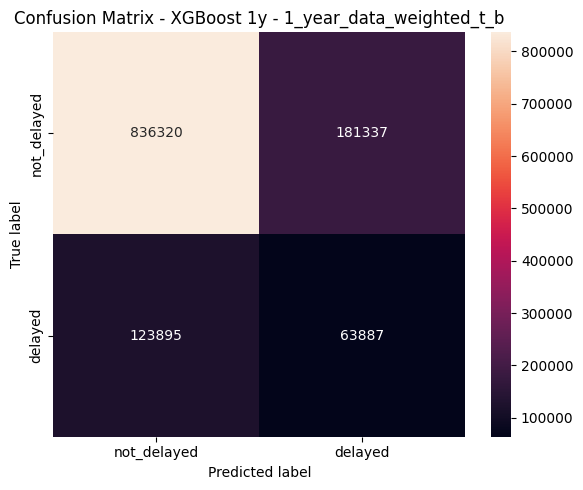

In [0]:
# XGBoost 1y model evaluations
cm_xg_1y = []
for model in xg_models_1y:
    _, _, _, _, cm = evaluate_model(model["model"], model["pred_test"], f"XGBoost 1y - {model['name']}")
    cm_xg_1y.append(cm)

=== Random Forest 1y - 1_year_data_weighted_t_b ===
Test accuracy : 0.7249
Test F1-score: 0.7458
Test precision: 0.7739
Test recall   : 0.7249


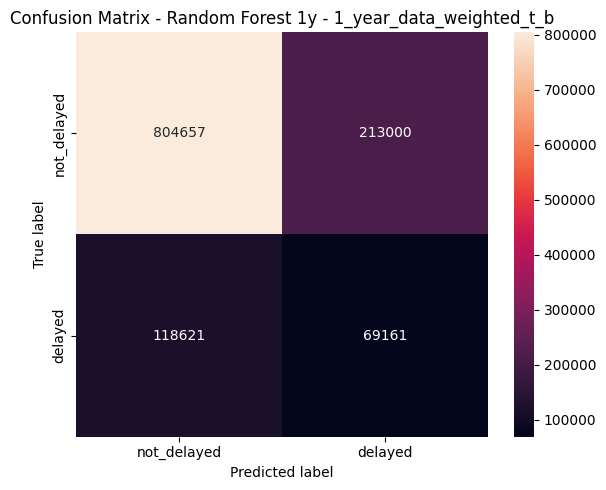

In [0]:
# Random Forest 1y model evaluations
cm_rf_1y = []
for model in rf_models_1y:
    _, _, _, _, cm = evaluate_model(model["model"], model["pred_test"], f"Random Forest 1y - {model['name']}")
    cm_rf_1y.append(cm)

## Cross Validation

In [0]:
def rolling_quarter_cv(df, quarter_split_function, cols_to_remove, start_quarter=1, end_quarter=4, chosen_cols=None):
    """
    - Full dataframe or target dataframe
    - Quarter split function
    - Columns to remove from the dataframe
    - Start quarter for rolling CV
    - End quarter for rolling CV
    - Chosen columns for modeling
    """
    results = []
    for test_quarter in range(start_quarter, end_quarter):
        # Use get_train_test_filter_df for train/test split
        split_df = get_train_test_filter_df(
            df, 
            quarter_split_function, 
            cols_to_remove, 
            test_quarter,
            test_quarter + 1, 
            chosen_cols
        )

        items = {
            "name": f"train_{test_quarter}_qtrs-test_qtr_{test_quarter + 1}",
            "train_df":  split_df["train_df"],
            "test_df":  split_df["test_df"],
            "feature_cols":  split_df["feature_cols"],
        }
        results.append(items)

    return results

In [0]:
def prepare_cv_pipeline(dfs, cols_to_remove, target):
    cv_datasets = []
    for df in dfs:
        res = rolling_quarter_cv(
            df,
            quarter_split,
            cols_to_remove,
            1,
            3,
            target
        )
        cv_datasets.extend(res)

    return cv_datasets

cv_dataset = prepare_cv_pipeline(dfs_1y, cols_to_remove, target_selected)

In [0]:
for cv in cv_dataset:
    print(cv["name"])

train_1_qtrs-test_qtr_2
train_2_qtrs-test_qtr_3


In [0]:
xg_cv = train_models(cv_dataset, train_xgboost, "weighted_xgboost_model__bin_t_qtr_cv")
rf_cv = train_models(cv_dataset, train_random_forest, "weighted_rf_model_bin_t_qtr_cv")

Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_1_qtrs-test_qtr_2
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_1_qtrs-test_qtr_2_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_1_qtrs-test_qtr_2_train_time.txt: 29.405596017837524
Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_2_qtrs-test_qtr_3
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_2_qtrs-test_qtr_3_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_2_qtrs-test_qtr_3_train_time.txt: 54.5403573513031
Loaded model from dbfs:/student-groups/Group_4_1/weighted_rf_model_bin_t_qtr_cv/train_1_qtrs-test_qtr_2
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_rf_model_bin_t_qtr_cv/train_1_qtrs-test_qtr_2_pred_test


In [0]:
# for i in rf_cv:
#     delete_model_if_exists("dbfs:/student-groups/Group_4_1/weighted_rf_model_bin_t_qtr_cv", i["name"])

# for i in xg_cv:
#     delete_model_if_exists("dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv", i["name"])

In [0]:
def rolling_evaluation(model_results, eval_fn, title_prefix=""):
    """
    Evaluate each CV split using eval_fn(model, pred_test, title).
    Returns a list of dicts with cv_name and individual metrics for CV calculation.
    """
    metrics = []
    for res in model_results:
        title = f"{title_prefix}{res['name']}"
        acc, f1, prec, rec, cm = eval_fn(res["model"], res["pred_test"], title)
        metrics.append({
            "cv_name": res["name"],
            "accuracy": acc,
            "f1": f1,
            "precision": prec,
            "recall": rec,
            "confusion_matrix": cm
        })
    return metrics

=== XGBoost CV - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6819
Test F1-score: 0.7046
Test precision: 0.7394
Test recall   : 0.6819


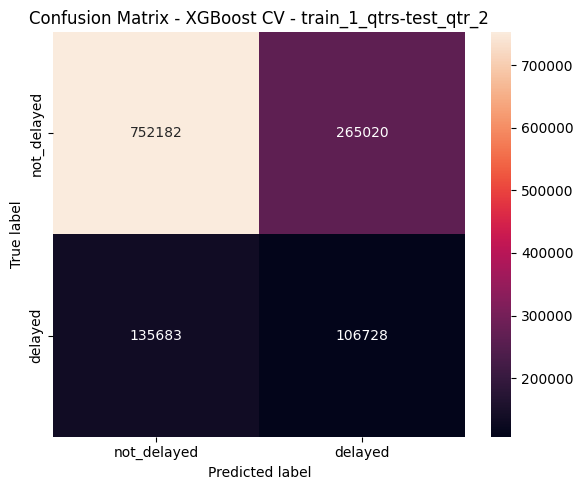

=== XGBoost CV - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.5870
Test F1-score: 0.6355
Test precision: 0.7830
Test recall   : 0.5870


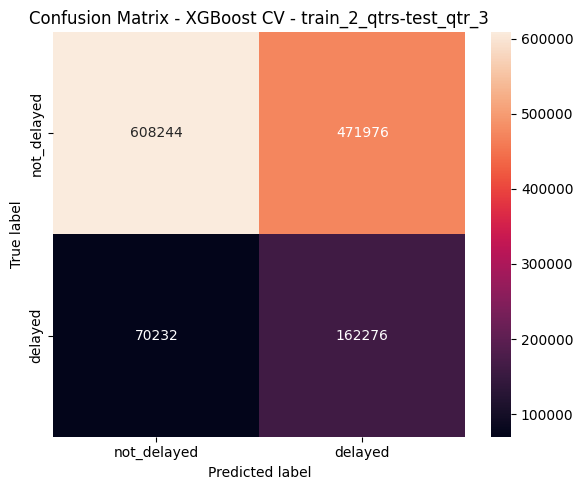

=== Random Forest CV - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6903
Test F1-score: 0.7046
Test precision: 0.7226
Test recall   : 0.6903


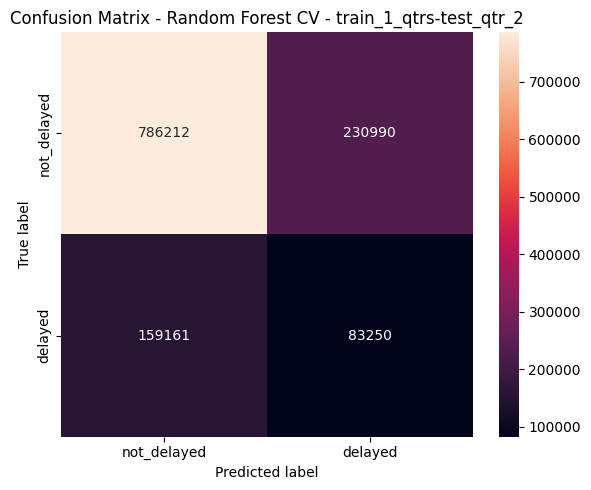

=== Random Forest CV - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.5927
Test F1-score: 0.6408
Test precision: 0.7778
Test recall   : 0.5927


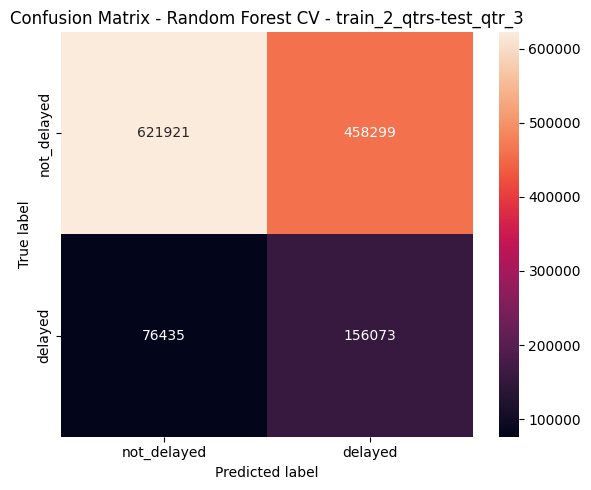

In [0]:
xg_cv_metrics = rolling_evaluation(xg_cv, evaluate_model, title_prefix="XGBoost CV - ")
rf_cv_metrics = rolling_evaluation(rf_cv, evaluate_model, title_prefix="Random Forest CV - ")

In [0]:
# Convert metrics lists to DataFrame for aggregation
xg_cv_metrics_df = pd.DataFrame(xg_cv_metrics)
rf_cv_metrics_df = pd.DataFrame(rf_cv_metrics)

# Compute mean for each metric
xg_cv_avg_metrics = xg_cv_metrics_df[["accuracy", "f1", "precision", "recall"]].mean()
rf_cv_avg_metrics = rf_cv_metrics_df[["accuracy", "f1", "precision", "recall"]].mean()

print("XGBoost CV average metrics:")
print(xg_cv_avg_metrics)

print("\nRandom Forest CV average metrics:")
print(rf_cv_avg_metrics)

XGBoost CV average metrics:
accuracy     0.634422
f1           0.670044
precision    0.761206
recall       0.634422
dtype: float64

Random Forest CV average metrics:
accuracy     0.641458
f1           0.672670
precision    0.750195
recall       0.641458
dtype: float64


## Confusion matrix for specific class

In [0]:
def precision_recall_f1_accuracy_for_class(cls, cm):
    TP = cm[cls, cls]
    FN = cm[cls, :].sum() - TP
    FP = cm[:, cls].sum() - TP
    TN = cm.sum() - TP - FN - FP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

    return precision, recall, f1, accuracy

In [0]:
print(cm_xg_1y)

[array([[836320, 181337],
       [123895,  63887]])]


In [0]:
# DM for field delayed
for i in range(len(cm_xg_1y)):
    res_delay_xg_1y = precision_recall_f1_accuracy_for_class(1, cm_xg_1y[i])

    res_delay_rf_1y = precision_recall_f1_accuracy_for_class(1, cm_rf_1y[i])

In [0]:
res_delay_xg_cv = []
for i in xg_cv_metrics:
    res = precision_recall_f1_accuracy_for_class(1, i["confusion_matrix"])
    res_delay_xg_cv.append(res)

res_delay_rf_cv = []
for i in rf_cv_metrics:
    res = precision_recall_f1_accuracy_for_class(1, i["confusion_matrix"])
    res_delay_rf_cv.append(res)

In [0]:
report_metrics = lambda x: f"Precision: {x[0]}, Recall: {x[1]}, F1: {x[2]}, Accuracy: {x[3]}"

report_metrics(res_delay_xg_1y)

'Precision: 0.2605250709555345, Recall: 0.3402189773247702, F1: 0.295085980332836, Accuracy: 0.7467876848185598'

In [0]:
report_metrics(res_delay_rf_1y)

'Precision: 0.2451118333150223, Recall: 0.3683047363432065, F1: 0.2943378239488619, Accuracy: 0.7248960752057964'

In [0]:
# Get all metrics of a certain obs, then sum and finally take the average
def get_summary_of_cv(metrics):
    precision = []
    recall = []
    f1 = []
    accuracy = []

    for i in metrics:
        precision.append(i[0])
        recall.append(i[1])
        f1.append(i[2])
        accuracy.append(i[3])

    p = sum(precision) / len(precision)
    r = sum(recall) / len(recall)
    f = sum(f1) / len(f1)
    a = sum(accuracy) / len(accuracy)

    print(report_metrics((p, r, f, a)))

In [0]:
get_summary_of_cv(res_delay_xg_cv)

Precision: 0.27147592567384027, Recall: 0.5691071627052066, F1: 0.3610004789651158, Accuracy: 0.6344224663185261


In [0]:
get_summary_of_cv(res_delay_rf_cv)

Precision: 0.2594807702309512, Recall: 0.5073418164751726, F1: 0.33384686049856643, Accuracy: 0.6414577979759499


Grid Search optimizations

In [0]:
def grid_search_wrapper(
    df_train,
    df_test,
    features_col,
    base_train_fn,
    param_grid,
    evaluate_fn,
    gs_save_path="",
    model_name="",
    adjust_fns=None,
    maximize=True,
):
    if adjust_fns is None:
        adjust_fns = []

    train_df = df_train
    test_df = df_test
    for fn in adjust_fns:
        train_df, test_df = fn(train_df, test_df)

    cache_enabled = (gs_save_path != "") and (model_name != "")
    if cache_enabled:
        base_path = f"{gs_save_path}/{model_name}"
        best_model_path = f"{base_path}/best_model"
        best_pred_path = f"{base_path}/best_pred_test"
        best_params_path = f"{base_path}/best_params.json"
        best_score_path = f"{base_path}/best_score.txt"
        time_save_path = f"{base_path}/train_time.txt"

        try:
            best_model = PipelineModel.load(best_model_path)
            best_pred_test = spark.read.parquet(best_pred_path)

            try:
                params_content = dbutils.fs.head(best_params_path, 10000)
                best_params = json.loads(params_content)
            except Exception:
                best_params = None

            try:
                score_content = dbutils.fs.head(best_score_path, 1000)
                best_score = float(score_content.strip())
            except Exception:
                best_score = None

            try:
                time_content = dbutils.fs.head(time_save_path, 1000)
                train_time = float(time_content.strip())
            except Exception:
                train_time = None

            return best_model, best_pred_test, best_params, best_score

        except Exception:
            pass

    param_names = list(param_grid.keys())
    param_values = [param_grid[k] for k in param_names]

    best_model = None
    best_pred_test = None
    best_params = None
    best_score = None

    start_time = time.time()

    for values in product(*param_values):
        params = dict(zip(param_names, values))
        model, pred_test = base_train_fn(train_df, test_df, features_col, **params)
        score = evaluate_fn(model, pred_test)

        if best_score is None:
            is_better = True
        else:
            is_better = (score > best_score) if maximize else (score < best_score)

        if is_better:
            best_score = score
            best_model = model
            best_pred_test = pred_test
            best_params = params

    end_time = time.time()
    train_time = end_time - start_time

    if cache_enabled and best_model is not None:
        base_path = f"{gs_save_path}/{model_name}"
        best_model.write().overwrite().save(f"{base_path}/best_model")
        best_pred_test.write.mode("overwrite").parquet(f"{base_path}/best_pred_test")
        dbutils.fs.put(f"{base_path}/best_params.json", json.dumps(best_params), overwrite=True)
        dbutils.fs.put(f"{base_path}/best_score.txt", str(best_score), overwrite=True)
        dbutils.fs.put(f"{base_path}/train_time.txt", str(train_time), overwrite=True)

    return best_model, best_pred_test, best_params, best_score

In [0]:
def train_random_forest_with_params(
    df_train,
    df_test,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    numTrees=150,
    maxDepth=8,
    maxBins=32,
    featureSubsetStrategy="auto",
    seed=42,
):
    stages = []
    stages.append(StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep"))

    if isinstance(features_col, list):
        stages.append(VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid="keep"))
        features_input_col = "features"
    else:
        features_input_col = features_col

    rf = RandomForestClassifier(
        featuresCol=features_input_col,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol="class_weight",
        numTrees=numTrees,
        maxDepth=maxDepth,
        maxBins=maxBins,
        featureSubsetStrategy=featureSubsetStrategy,
        seed=seed,
    )
    stages.append(rf)

    model = Pipeline(stages=stages).fit(df_train)
    pred_test = model.transform(df_test)
    return model, pred_test

In [0]:
def random_forest_grid_search(
    df_train,
    df_test,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    param_grid=None,
    evaluate_fn=None,
    gs_save_path="",
    model_name="",
    adjust_fns=None,
    maximize=True,
):
    if param_grid is None:
        param_grid = {
            "numTrees": [100, 150],
            "maxDepth": [6, 8],
            "maxBins": [32, 64],
            "featureSubsetStrategy": ["auto", "sqrt"],
        }

    if evaluate_fn is None:
        def evaluate_fn(m, pred):
            acc, f1, prec, rec, cm = evaluate_model(m, pred, "")
            return rec

    def base_train_fn(df_tr, df_te, feats, **params):
        return train_random_forest_with_params(df_tr, df_te, feats, label_col=label_col, **params)

    return grid_search_wrapper(
        df_train,
        df_test,
        features_col,
        base_train_fn,
        param_grid,
        evaluate_fn,
        gs_save_path,
        model_name,
        adjust_fns,
        maximize,
    )



In [0]:
def train_xgboost_with_params(
    df_train,
    df_test,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
):
    stages = []
    stages.append(StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep"))

    if isinstance(features_col, list):
        stages.append(VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid="keep"))
        features_input_col = "features"
    else:
        features_input_col = features_col

    xgb = SparkXGBClassifier(
        features_col=features_input_col,
        label_col="label",
        weight_col="class_weight",
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
    )
    stages.append(xgb)

    model = Pipeline(stages=stages).fit(df_train)
    pred_test = model.transform(df_test)
    return model, pred_test

In [0]:

def xgboost_grid_search(
    df_train,
    df_test,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    param_grid=None,
    evaluate_fn=None,
    gs_save_path="",
    model_name="",
    adjust_fns=None,
    maximize=True,
):
    if param_grid is None:
        param_grid = {
            "max_depth": [4, 6, 8],
            "n_estimators": [100, 150],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "reg_lambda": [1.0, 2.0],
            "reg_alpha": [0.0, 1.0],
        }

    if evaluate_fn is None:
        def evaluate_fn(m, pred):
            acc, f1, prec, rec, cm = evaluate_model(m, pred, "")
            return rec

    def base_train_fn(df_tr, df_te, feats, **params):
        return train_xgboost_with_params(df_tr, df_te, feats, label_col=label_col, **params)

    return grid_search_wrapper(
        df_train,
        df_test,
        features_col,
        base_train_fn,
        param_grid,
        evaluate_fn,
        gs_save_path,
        model_name,
        adjust_fns,
        maximize,
    )

In [0]:
df_train = df_split_1y[0]["train_df"]
df_test = df_split_1y[0]["test_df"]
features_col = df_split_1y[0]["feature_cols"]
split_name = df_split_1y[0]["name"]

In [0]:
xgb_best_model, xgb_best_pred, xgb_best_params, xgb_best_score = xgboost_grid_search(
    df_train=df_train,
    df_test=df_test,
    features_col=features_col,
    gs_save_path="dbfs:/student-groups/Group_4_1/xgb_gridsearch",
    model_name=split_name,
    adjust_fns=[add_class_weights()],
)


print("XGB best recall:", xgb_best_score)
print("XGB best params:", xgb_best_params)

2025-11-23 01:25:00,511 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:26:20,044 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7201
Test F1-score: 0.7431
Test precision: 0.7749
Test recall   : 0.7201


2025-11-23 01:27:15,922 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:28:25,453 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7173
Test F1-score: 0.7416
Test precision: 0.7758
Test recall   : 0.7173


2025-11-23 01:29:06,610 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:30:12,880 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7205
Test F1-score: 0.7433
Test precision: 0.7748
Test recall   : 0.7205


2025-11-23 01:30:52,824 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:31:57,834 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7201
Test F1-score: 0.7430
Test precision: 0.7745
Test recall   : 0.7201


2025-11-23 01:32:38,061 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:33:43,125 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7242
Test F1-score: 0.7456
Test precision: 0.7745
Test recall   : 0.7242


2025-11-23 01:34:23,872 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:35:30,223 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7278
Test F1-score: 0.7477
Test precision: 0.7740
Test recall   : 0.7278


2025-11-23 01:36:09,956 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:37:14,431 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7239
Test F1-score: 0.7454
Test precision: 0.7746
Test recall   : 0.7239


2025-11-23 01:37:54,311 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:39:00,031 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7278
Test F1-score: 0.7477
Test precision: 0.7740
Test recall   : 0.7278


2025-11-23 01:39:39,479 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:40:43,826 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7148
Test F1-score: 0.7398
Test precision: 0.7753
Test recall   : 0.7148


2025-11-23 01:41:23,159 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:42:25,504 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7203
Test F1-score: 0.7433
Test precision: 0.7753
Test recall   : 0.7203


2025-11-23 01:43:04,321 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:44:10,013 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7177
Test F1-score: 0.7415
Test precision: 0.7750
Test recall   : 0.7177


2025-11-23 01:44:48,620 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:45:50,920 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7202
Test F1-score: 0.7433
Test precision: 0.7753
Test recall   : 0.7202


2025-11-23 01:46:29,804 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:47:31,618 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7205
Test F1-score: 0.7432
Test precision: 0.7745
Test recall   : 0.7205


2025-11-23 01:48:08,972 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:49:10,725 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7206
Test F1-score: 0.7433
Test precision: 0.7746
Test recall   : 0.7206


2025-11-23 01:49:48,270 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:50:50,131 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7206
Test F1-score: 0.7433
Test precision: 0.7746
Test recall   : 0.7206


2025-11-23 01:51:27,872 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:52:29,219 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7187
Test F1-score: 0.7423
Test precision: 0.7751
Test recall   : 0.7187


2025-11-23 01:53:06,688 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:54:10,284 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7306
Test F1-score: 0.7499
Test precision: 0.7753
Test recall   : 0.7306


2025-11-23 01:54:48,090 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:55:52,324 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7251
Test F1-score: 0.7468
Test precision: 0.7766
Test recall   : 0.7251


2025-11-23 01:56:29,693 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:57:34,205 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7299
Test F1-score: 0.7501
Test precision: 0.7771
Test recall   : 0.7299


2025-11-23 01:58:11,972 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 01:59:16,893 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7299
Test F1-score: 0.7500
Test precision: 0.7769
Test recall   : 0.7299


2025-11-23 01:59:54,985 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:00:59,164 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7318
Test F1-score: 0.7508
Test precision: 0.7757
Test recall   : 0.7318


2025-11-23 02:01:36,981 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:02:43,268 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7321
Test F1-score: 0.7511
Test precision: 0.7763
Test recall   : 0.7321


2025-11-23 02:03:21,645 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:04:25,378 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7340
Test F1-score: 0.7524
Test precision: 0.7766
Test recall   : 0.7340


2025-11-23 02:05:02,910 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:06:07,499 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7339
Test F1-score: 0.7524
Test precision: 0.7768
Test recall   : 0.7339


2025-11-23 02:06:45,087 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:07:47,324 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7374
Test F1-score: 0.7538
Test precision: 0.7747
Test recall   : 0.7374


2025-11-23 02:08:24,965 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:10:00,203 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7336
Test F1-score: 0.7519
Test precision: 0.7757
Test recall   : 0.7336


2025-11-23 02:10:38,012 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:11:39,327 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7335
Test F1-score: 0.7519
Test precision: 0.7759
Test recall   : 0.7335


2025-11-23 02:12:16,853 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:13:17,448 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7379
Test F1-score: 0.7543
Test precision: 0.7752
Test recall   : 0.7379


2025-11-23 02:13:54,969 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:14:57,983 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7385
Test F1-score: 0.7547
Test precision: 0.7753
Test recall   : 0.7385


2025-11-23 02:15:35,551 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:16:36,639 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7369
Test F1-score: 0.7539
Test precision: 0.7756
Test recall   : 0.7369


2025-11-23 02:17:13,016 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:18:15,664 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7387
Test F1-score: 0.7550
Test precision: 0.7756
Test recall   : 0.7387


2025-11-23 02:18:52,411 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:19:53,893 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7384
Test F1-score: 0.7544
Test precision: 0.7744
Test recall   : 0.7384


2025-11-23 02:20:31,490 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:21:54,771 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7264
Test F1-score: 0.7473
Test precision: 0.7755
Test recall   : 0.7264


2025-11-23 02:22:33,830 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:23:55,939 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7253
Test F1-score: 0.7469
Test precision: 0.7766
Test recall   : 0.7253


2025-11-23 02:24:34,664 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:25:58,226 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7264
Test F1-score: 0.7473
Test precision: 0.7755
Test recall   : 0.7264


2025-11-23 02:26:37,077 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:28:03,221 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7254
Test F1-score: 0.7468
Test precision: 0.7757
Test recall   : 0.7254


2025-11-23 02:28:41,720 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:30:05,004 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7255
Test F1-score: 0.7468
Test precision: 0.7757
Test recall   : 0.7255


2025-11-23 02:30:43,613 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:32:06,370 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7342
Test F1-score: 0.7519
Test precision: 0.7747
Test recall   : 0.7342


2025-11-23 02:32:45,418 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:34:09,636 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7343
Test F1-score: 0.7522
Test precision: 0.7756
Test recall   : 0.7343


2025-11-23 02:34:48,988 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:36:11,211 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7356
Test F1-score: 0.7527
Test precision: 0.7747
Test recall   : 0.7356


2025-11-23 02:36:49,906 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:38:09,142 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7233
Test F1-score: 0.7455
Test precision: 0.7762
Test recall   : 0.7233


2025-11-23 02:38:48,545 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:40:10,588 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7312
Test F1-score: 0.7502
Test precision: 0.7753
Test recall   : 0.7312


2025-11-23 02:40:49,548 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:42:10,715 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7268
Test F1-score: 0.7477
Test precision: 0.7761
Test recall   : 0.7268


2025-11-23 02:42:49,728 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:44:11,886 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7311
Test F1-score: 0.7502
Test precision: 0.7753
Test recall   : 0.7311


2025-11-23 02:44:52,236 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:46:13,235 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7269
Test F1-score: 0.7476
Test precision: 0.7754
Test recall   : 0.7269


2025-11-23 02:46:52,785 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:48:13,086 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7300
Test F1-score: 0.7496
Test precision: 0.7757
Test recall   : 0.7300


2025-11-23 02:48:53,089 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:50:15,198 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7290
Test F1-score: 0.7489
Test precision: 0.7753
Test recall   : 0.7290


2025-11-23 02:50:54,995 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:52:17,012 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7255
Test F1-score: 0.7468
Test precision: 0.7759
Test recall   : 0.7255


2025-11-23 02:52:56,106 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:54:18,813 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7326
Test F1-score: 0.7516
Test precision: 0.7766
Test recall   : 0.7326


2025-11-23 02:54:58,679 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:56:21,507 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7328
Test F1-score: 0.7518
Test precision: 0.7768
Test recall   : 0.7328


2025-11-23 02:57:01,220 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 02:58:23,607 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7328
Test F1-score: 0.7517
Test precision: 0.7767
Test recall   : 0.7328


2025-11-23 02:59:03,065 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:00:24,053 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7362
Test F1-score: 0.7539
Test precision: 0.7768
Test recall   : 0.7362


2025-11-23 03:01:04,778 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:02:30,274 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7318
Test F1-score: 0.7511
Test precision: 0.7769
Test recall   : 0.7318


2025-11-23 03:03:09,931 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:04:32,594 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7314
Test F1-score: 0.7511
Test precision: 0.7773
Test recall   : 0.7314


2025-11-23 03:05:12,186 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:06:34,218 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7347
Test F1-score: 0.7529
Test precision: 0.7767
Test recall   : 0.7347


2025-11-23 03:07:13,600 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:08:35,321 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7292
Test F1-score: 0.7495
Test precision: 0.7766
Test recall   : 0.7292


2025-11-23 03:09:15,170 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:10:34,471 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7413
Test F1-score: 0.7568
Test precision: 0.7762
Test recall   : 0.7413


2025-11-23 03:11:15,194 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:12:36,131 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7384
Test F1-score: 0.7553
Test precision: 0.7771
Test recall   : 0.7384


2025-11-23 03:13:16,314 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:14:35,914 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7361
Test F1-score: 0.7538
Test precision: 0.7767
Test recall   : 0.7361


2025-11-23 03:15:16,412 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:16:38,370 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7390
Test F1-score: 0.7554
Test precision: 0.7764
Test recall   : 0.7390


2025-11-23 03:17:17,738 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:18:38,159 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7388
Test F1-score: 0.7553
Test precision: 0.7765
Test recall   : 0.7388


2025-11-23 03:19:18,949 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:20:38,153 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7349
Test F1-score: 0.7531
Test precision: 0.7771
Test recall   : 0.7349


2025-11-23 03:21:18,663 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:22:43,313 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7393
Test F1-score: 0.7557
Test precision: 0.7765
Test recall   : 0.7393


2025-11-23 03:23:23,781 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:24:42,405 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7395
Test F1-score: 0.7555
Test precision: 0.7757
Test recall   : 0.7395


2025-11-23 03:25:23,612 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:26:40,045 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7375
Test F1-score: 0.7541
Test precision: 0.7751
Test recall   : 0.7375


2025-11-23 03:27:20,731 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:28:39,755 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7399
Test F1-score: 0.7551
Test precision: 0.7741
Test recall   : 0.7399


2025-11-23 03:29:19,780 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:30:35,449 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7429
Test F1-score: 0.7568
Test precision: 0.7739
Test recall   : 0.7429


2025-11-23 03:31:15,947 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:32:33,784 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7410
Test F1-score: 0.7560
Test precision: 0.7746
Test recall   : 0.7410


2025-11-23 03:33:14,389 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:34:29,887 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7308
Test F1-score: 0.7502
Test precision: 0.7759
Test recall   : 0.7308


2025-11-23 03:35:10,538 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:37:04,840 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7330
Test F1-score: 0.7515
Test precision: 0.7757
Test recall   : 0.7330


2025-11-23 03:37:45,315 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:39:03,536 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7317
Test F1-score: 0.7508
Test precision: 0.7760
Test recall   : 0.7317


2025-11-23 03:39:44,225 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:40:59,244 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7358
Test F1-score: 0.7531
Test precision: 0.7754
Test recall   : 0.7358


2025-11-23 03:41:39,953 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:43:15,156 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7430
Test F1-score: 0.7572
Test precision: 0.7746
Test recall   : 0.7430


2025-11-23 03:43:55,952 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:45:12,266 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7414
Test F1-score: 0.7561
Test precision: 0.7743
Test recall   : 0.7414


2025-11-23 03:45:52,265 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:47:06,124 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7386
Test F1-score: 0.7547
Test precision: 0.7752
Test recall   : 0.7386


2025-11-23 03:47:46,442 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:48:59,621 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7402
Test F1-score: 0.7555
Test precision: 0.7745
Test recall   : 0.7402


2025-11-23 03:49:39,853 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:50:53,386 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7374
Test F1-score: 0.7543
Test precision: 0.7759
Test recall   : 0.7374


2025-11-23 03:51:33,240 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:52:48,484 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7362
Test F1-score: 0.7533
Test precision: 0.7752
Test recall   : 0.7362


2025-11-23 03:53:28,155 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:54:39,767 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7356
Test F1-score: 0.7531
Test precision: 0.7756
Test recall   : 0.7356


2025-11-23 03:55:19,431 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:56:33,174 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7359
Test F1-score: 0.7534
Test precision: 0.7760
Test recall   : 0.7359


2025-11-23 03:57:12,336 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:58:23,180 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7449
Test F1-score: 0.7585
Test precision: 0.7749
Test recall   : 0.7449


2025-11-23 03:59:02,700 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:00:15,314 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7451
Test F1-score: 0.7589
Test precision: 0.7759
Test recall   : 0.7451


2025-11-23 04:00:54,508 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:02:07,099 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7440
Test F1-score: 0.7584
Test precision: 0.7761
Test recall   : 0.7440


2025-11-23 04:02:46,092 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:04:01,497 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7474
Test F1-score: 0.7602
Test precision: 0.7758
Test recall   : 0.7474


2025-11-23 04:04:40,196 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:05:54,082 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7409
Test F1-score: 0.7568
Test precision: 0.7770
Test recall   : 0.7409


2025-11-23 04:06:33,269 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:07:46,003 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7390
Test F1-score: 0.7554
Test precision: 0.7763
Test recall   : 0.7390


2025-11-23 04:08:25,932 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:09:39,155 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7389
Test F1-score: 0.7553
Test precision: 0.7763
Test recall   : 0.7389


2025-11-23 04:10:18,674 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:11:32,013 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7413
Test F1-score: 0.7570
Test precision: 0.7770
Test recall   : 0.7413


2025-11-23 04:12:11,274 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:13:22,908 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7486
Test F1-score: 0.7604
Test precision: 0.7745
Test recall   : 0.7486


2025-11-23 04:14:02,217 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:15:14,436 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7434
Test F1-score: 0.7572
Test precision: 0.7742
Test recall   : 0.7434


2025-11-23 04:15:54,382 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:17:06,382 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7515
Test F1-score: 0.7622
Test precision: 0.7746
Test recall   : 0.7515


2025-11-23 04:17:44,006 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:18:57,056 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7428
Test F1-score: 0.7569
Test precision: 0.7742
Test recall   : 0.7428


2025-11-23 04:19:37,077 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:20:48,824 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7387
Test F1-score: 0.7553
Test precision: 0.7766
Test recall   : 0.7387


2025-11-23 04:21:28,640 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:22:40,401 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7416
Test F1-score: 0.7571
Test precision: 0.7766
Test recall   : 0.7416


2025-11-23 04:23:19,497 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:24:31,832 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7417
Test F1-score: 0.7569
Test precision: 0.7759
Test recall   : 0.7417


2025-11-23 04:25:11,197 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:26:23,317 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7400
Test F1-score: 0.7561
Test precision: 0.7765
Test recall   : 0.7400


2025-11-23 04:27:01,828 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:28:40,560 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7433
Test F1-score: 0.7577
Test precision: 0.7755
Test recall   : 0.7433


2025-11-23 04:29:21,072 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:31:00,223 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7428
Test F1-score: 0.7572
Test precision: 0.7751
Test recall   : 0.7428


2025-11-23 04:31:41,244 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:33:19,105 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7433
Test F1-score: 0.7577
Test precision: 0.7756
Test recall   : 0.7433


2025-11-23 04:34:00,241 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:35:38,274 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7424
Test F1-score: 0.7570
Test precision: 0.7752
Test recall   : 0.7424


2025-11-23 04:36:19,172 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:37:55,936 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7388
Test F1-score: 0.7555
Test precision: 0.7769
Test recall   : 0.7388


2025-11-23 04:38:36,932 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:40:14,728 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7397
Test F1-score: 0.7559
Test precision: 0.7765
Test recall   : 0.7397


2025-11-23 04:40:55,398 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:42:32,877 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7395
Test F1-score: 0.7559
Test precision: 0.7771
Test recall   : 0.7395


2025-11-23 04:43:13,582 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:44:50,895 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7378
Test F1-score: 0.7547
Test precision: 0.7765
Test recall   : 0.7378


2025-11-23 04:45:31,907 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:47:08,850 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7450
Test F1-score: 0.7588
Test precision: 0.7758
Test recall   : 0.7450


2025-11-23 04:47:49,581 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:49:24,114 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7459
Test F1-score: 0.7593
Test precision: 0.7756
Test recall   : 0.7459


2025-11-23 04:50:05,287 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:51:47,762 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7436
Test F1-score: 0.7580
Test precision: 0.7758
Test recall   : 0.7436


2025-11-23 04:52:28,724 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:54:03,404 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7437
Test F1-score: 0.7579
Test precision: 0.7755
Test recall   : 0.7437


2025-11-23 04:54:44,147 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:56:19,973 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7411
Test F1-score: 0.7569
Test precision: 0.7768
Test recall   : 0.7411


2025-11-23 04:57:00,621 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 04:58:35,202 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7427
Test F1-score: 0.7576
Test precision: 0.7760
Test recall   : 0.7427


2025-11-23 04:59:16,018 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:00:52,381 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7389
Test F1-score: 0.7554
Test precision: 0.7765
Test recall   : 0.7389


2025-11-23 05:01:32,875 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:03:13,861 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7401
Test F1-score: 0.7563
Test precision: 0.7769
Test recall   : 0.7401


2025-11-23 05:03:54,738 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:05:29,529 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7441
Test F1-score: 0.7586
Test precision: 0.7766
Test recall   : 0.7441


2025-11-23 05:06:09,809 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:07:43,577 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7464
Test F1-score: 0.7601
Test precision: 0.7770
Test recall   : 0.7464


2025-11-23 05:08:24,074 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:10:03,513 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7426
Test F1-score: 0.7578
Test precision: 0.7770
Test recall   : 0.7426


2025-11-23 05:10:44,911 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:12:22,226 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7454
Test F1-score: 0.7595
Test precision: 0.7768
Test recall   : 0.7454


2025-11-23 05:13:02,655 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:14:41,392 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7398
Test F1-score: 0.7563
Test precision: 0.7775
Test recall   : 0.7398


2025-11-23 05:15:23,085 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:16:57,942 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7405
Test F1-score: 0.7566
Test precision: 0.7771
Test recall   : 0.7405


2025-11-23 05:17:38,465 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:19:12,812 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7402
Test F1-score: 0.7564
Test precision: 0.7771
Test recall   : 0.7402


2025-11-23 05:19:54,413 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:21:28,605 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7433
Test F1-score: 0.7585
Test precision: 0.7775
Test recall   : 0.7433


2025-11-23 05:22:12,195 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:23:43,452 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7501
Test F1-score: 0.7618
Test precision: 0.7757
Test recall   : 0.7501


2025-11-23 05:24:25,324 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 05:26:01,685 INFO XGBoost-PySpark: _fit Finished xgboost training!


===  ===
Test accuracy : 0.7448
Test F1-score: 0.7583
Test precision: 0.7747
Test recall   : 0.7448


2025-11-23 05:26:42,974 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 1.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
rf_best_model, rf_best_pred, rf_best_params, rf_best_score = random_forest_grid_search(
    df_train=df_train,
    df_test=df_test,
    features_col=features_col,
    gs_save_path="dbfs:/student-groups/Group_4_1/rf_gridsearch",
    model_name=split_name,
    adjust_fns=[add_class_weights()],
)


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data

In [0]:
print("RF best recall:", rf_best_score)
print("RF best params:", rf_best_params)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:134)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.data